In [3]:
import sqlite3
import pandas as pd

# File path
csv_path = r"C:\Users\human being\Desktop\data.csv"

# Load CSV
df = pd.read_csv(csv_path)

# Replace commas in genres to avoid SQL issues (e.g., "Comedy, Drama" -> "Comedy|Drama")
df['genres'] = df['genres'].str.replace(', ', '|', regex=False)

# Create SQLite database
db_path = r"C:\Users\human being\Desktop\streaming.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Create table
cursor.execute("""
CREATE TABLE IF NOT EXISTS streaming_data (
    title TEXT,
    type TEXT,
    genres TEXT,
    releaseYear INTEGER,
    imdbId TEXT,
    imdbAverageRating REAL,
    imdbNumVotes INTEGER
)
""")

# Insert data
df.to_sql('streaming_data', conn, if_exists='replace', index=False)

# Sample Query 1: Count titles by type and sentiment
cursor.execute("""
WITH Sentiment AS (
    SELECT type, 
           CASE 
               WHEN imdbAverageRating >= 7 THEN 'High'
               WHEN imdbAverageRating < 7 AND imdbAverageRating >= 5.5 THEN 'Neutral'
               WHEN imdbAverageRating < 5.5 THEN 'Low'
               ELSE 'Missing'
           END AS sentiment,
           COUNT(*) AS title_count
    FROM streaming_data
    GROUP BY type, sentiment
)
SELECT type, sentiment, title_count, 
       ROUND(100.0 * title_count / SUM(title_count) OVER (PARTITION BY type), 2) AS percentage
FROM Sentiment
ORDER BY type, sentiment;
""")
print("Query 1: Sentiment Distribution by Type")
for row in cursor.fetchall():
    print(row)

# Sample Query 2: Top 5 genres by average rating for movies
cursor.execute("""
SELECT genres, AVG(imdbAverageRating) AS avg_rating, COUNT(*) AS title_count
FROM streaming_data
WHERE type = 'movie' AND imdbAverageRating IS NOT NULL
GROUP BY genres
HAVING title_count >= 5
ORDER BY avg_rating DESC
LIMIT 5;
""")
print("\nQuery 2: Top 5 Movie Genres by Average Rating")
for row in cursor.fetchall():
    print(row)

# Commit and close
conn.commit()
conn.close()

print(f"Database created at {db_path}")

Query 1: Sentiment Distribution by Type
('movie', 'High', 3752, 23.08)
('movie', 'Low', 3172, 19.51)
('movie', 'Missing', 1050, 6.46)
('movie', 'Neutral', 8283, 50.95)
('tv', 'High', 2613, 49.87)
('tv', 'Low', 289, 5.52)
('tv', 'Missing', 749, 14.29)
('tv', 'Neutral', 1589, 30.32)

Query 2: Top 5 Movie Genres by Average Rating
('Adventure|Comedy|Sci-Fi', 7.74, 5)
('Music', 7.509090909090909, 11)
('Documentary|Family', 7.5, 6)
('Adventure|Documentary|Sport', 7.5, 6)
('Biography|Documentary|History', 7.466666666666667, 42)
Database created at C:\Users\human being\Desktop\streaming.db


In [5]:
import pandas as pd

# File path
csv_path = r"C:\Users\human being\Desktop\data.csv"
output_path = r"C:\Users\human being\Desktop\data_cleaned.csv"

# Load CSV
df = pd.read_csv(csv_path)

# Initial inspection
print("Initial Row Count:", len(df))
print("Missing Values:\n", df.isnull().sum())

# Step 1: Handle missing titles (drop if empty)
df = df.dropna(subset=['title'])
df = df.drop('Unnamed: 7', axis=1)
print("Rows after dropping empty titles:", len(df))

# Step 2: Handle missing imdbAverageRating (impute with genre median for movies, filter for TV)
df['genres'] = df['genres'].fillna('Unknown')  # Fill empty genres
median_ratings = df[df['type'] == 'movie'].groupby('genres')['imdbAverageRating'].median()
df['imdbAverageRating'] = df.apply(
    lambda x: median_ratings.get(x['genres'], 6.5) if pd.isna(x['imdbAverageRating']) and x['type'] == 'movie' else x['imdbAverageRating'],
    axis=1
)
# For TV shows, drop if rating is missing (less reliable imputation)
df = df[~((df['type'] == 'tv') & (df['imdbAverageRating'].isna()))]
print("Rows after handling ratings:", len(df))

# Step 3: Add sentiment column
df['sentiment'] = df['imdbAverageRating'].apply(
    lambda x: 'High' if x >= 7 else 'Low' if x < 5.5 else 'Neutral'
)

# Step 4: Parse genres (keep original and create split list)
df['genres_list'] = df['genres'].str.split(', ')
df['genres_list'] = df['genres_list'].apply(lambda x: x if isinstance(x, list) else ['Unknown'])

# Step 5: Clean other columns
df['type'] = df['type'].fillna('Unknown')
df['releaseYear'] = df['releaseYear'].fillna(df['releaseYear'].median())
df['imdbNumVotes'] = df['imdbNumVotes'].fillna(0)

# Final inspection
print("Final Row Count:", len(df))
print("Sample Data:\n", df[['title', 'type', 'genres', 'sentiment', 'genres_list']].head())

# Save cleaned CSV
df.to_csv(output_path, index=False)
print(f"Cleaned data saved to {output_path}")

Initial Row Count: 21497
Missing Values:
 title                  711
type                     0
genres                 371
releaseYear             41
imdbId                1607
imdbAverageRating     1799
imdbNumVotes          1799
Unnamed: 7           21338
dtype: int64
Rows after dropping empty titles: 20786
Rows after handling ratings: 20748
Final Row Count: 20748
Sample Data:
                  title   type                     genres sentiment  \
0                Ariel  movie     Comedy, Crime, Romance      High   
1  Shadows in Paradise  movie       Comedy, Drama, Music      High   
2         Forrest Gump  movie             Drama, Romance      High   
3      American Beauty  movie                      Drama      High   
4    The Fifth Element  movie  Action, Adventure, Sci-Fi      High   

                   genres_list  
0     [Comedy, Crime, Romance]  
1       [Comedy, Drama, Music]  
2             [Drama, Romance]  
3                      [Drama]  
4  [Action, Adventure, Sci-Fi] 

In [7]:

# Set file paths
db_path = r"C:\Users\human being\Desktop\streaming.db"
output_dir = r"C:\Users\human being\Desktop"

# Connect to SQLite database
conn = sqlite3.connect(db_path)

# Query 1: Sentiment Distribution by Type
query1 = """
WITH SentimentByType AS (
    SELECT type, 
           CASE 
               WHEN imdbAverageRating >= 7 THEN 'High'
               WHEN imdbAverageRating >= 5.5 AND imdbAverageRating < 7 THEN 'Neutral'
               WHEN imdbAverageRating < 5.5 THEN 'Low'
               ELSE 'Missing'
           END AS sentiment,
           COUNT(*) AS title_count,
           SUM(imdbNumVotes) AS total_votes
    FROM streaming_data
    GROUP BY type, sentiment
)
SELECT type, sentiment, title_count, 
       ROUND(100.0 * title_count / SUM(title_count) OVER (PARTITION BY type), 2) AS pct_titles,
       ROUND(100.0 * total_votes / SUM(total_votes) OVER (PARTITION BY type), 2) AS pct_votes
FROM SentimentByType
WHERE sentiment != 'Missing'
ORDER BY type, 
         CASE sentiment 
             WHEN 'High' THEN 1 
             WHEN 'Neutral' THEN 2 
             WHEN 'Low' THEN 3 
         END;
"""
df1 = pd.read_sql_query(query1, conn)
print("Query 1: Sentiment Distribution by Type")
display(df1)
df1.to_csv(f"{output_dir}\\sentiment_by_type.csv", index=False)

# Query 2: Top 5 Genres by % High Ratings (Movies Only, Min 10 Titles)
query2 = """
WITH SentimentByGenre AS (
    SELECT genres, 
           COUNT(*) AS title_count,
           COUNT(CASE WHEN imdbAverageRating >= 7 THEN 1 END) AS high_count,
           AVG(imdbAverageRating) AS avg_rating,
           SUM(imdbNumVotes) AS total_votes
    FROM streaming_data
    WHERE type = 'movie' AND imdbAverageRating IS NOT NULL
    GROUP BY genres
    HAVING title_count >= 10
)
SELECT genres, title_count, 
       ROUND(100.0 * high_count / title_count, 2) AS pct_high,
       ROUND(avg_rating, 2) AS avg_rating,
       total_votes
FROM SentimentByGenre
ORDER BY pct_high DESC, avg_rating DESC
LIMIT 5;
"""
df2 = pd.read_sql_query(query2, conn)
print("\nQuery 2: Top 5 Movie Genres by % High Ratings")
display(df2)
df2.to_csv(f"{output_dir}\\top_genres_by_high_ratings.csv", index=False)

# Query 3: Genre and Type Distribution
query3 = """
SELECT type, 
       CASE WHEN genres = 'Unknown' THEN 'Unknown' ELSE genres END AS genres,
       COUNT(*) AS title_count,
       ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (PARTITION BY type), 2) AS pct_type
FROM streaming_data
GROUP BY type, genres
HAVING title_count >= 5
ORDER BY type, title_count DESC
LIMIT 10;
"""
df3 = pd.read_sql_query(query3, conn)
print("\nQuery 3: Genre and Type Distribution")
display(df3)
df3.to_csv(f"{output_dir}\\genre_type_distribution.csv", index=False)

# Close connection
conn.close()

print(f"Results saved to {output_dir}\\sentiment_by_type.csv, top_genres_by_high_ratings.csv, genre_type_distribution.csv")

Query 1: Sentiment Distribution by Type


,type,sentiment,title_count,pct_titles,pct_votes
0,movie,High,3752,24.67,59.55
1,movie,Neutral,8283,54.47,35.79
2,movie,Low,3172,20.86,4.66
3,tv,High,2613,58.18,90.38
4,tv,Neutral,1589,35.38,8.55
5,tv,Low,289,6.44,1.07



Query 2: Top 5 Movie Genres by % High Ratings


,genres,title_count,pct_high,avg_rating,total_votes
0,Animation|Drama|Fantasy,18,88.89,7.46,714304.0
1,Animation|Drama|Family,12,83.33,7.47,584916.0
2,Documentary|War,12,83.33,7.36,62833.0
3,Music,11,81.82,7.51,2356.0
4,Biography|Documentary|History,42,78.57,7.47,140999.0



Query 3: Genre and Type Distribution


,type,genres,title_count,pct_type
0,movie,Comedy,1564,10.06
1,movie,Drama,1342,8.63
2,movie,Documentary,806,5.18
3,movie,Comedy|Drama,685,4.40
4,movie,Comedy|Romance,592,3.81
5,movie,Drama|Romance,548,3.52
6,movie,Comedy|Drama|Romance,505,3.25
7,movie,Action|Crime|Drama,327,2.10
8,movie,Adventure|Animation|Comedy,263,1.69
9,movie,Action|Adventure|Animation,235,1.51


Results saved to C:\Users\human being\Desktop\sentiment_by_type.csv, top_genres_by_high_ratings.csv, genre_type_distribution.csv


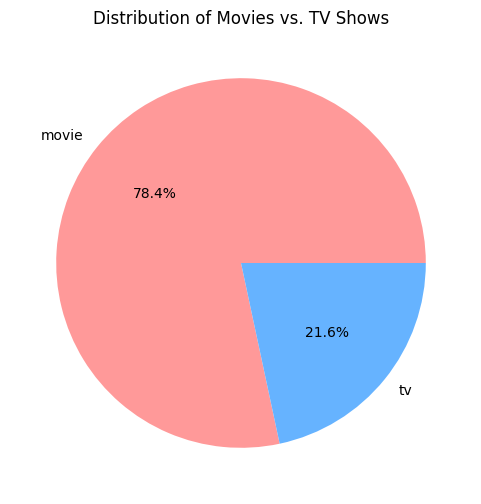

Type Distribution:
 type
movie    16257
tv        4491
Name: count, dtype: int64

Sentiment Distribution (%):
 sentiment       High        Low    Neutral
type                                      
movie      25.896537  19.689980  54.413483
tv         58.183033   6.435092  35.381875


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# File path
csv_path = r"C:\Users\human being\Desktop\data_cleaned.csv"
output_dir = r"C:\Users\human being\Desktop"

# Load cleaned CSV
df = pd.read_csv(csv_path, low_memory=False)

# Convert genres_list from string to list (if saved as string in CSV)
df['genres_list'] = df['genres_list'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# EDA : Type Distribution
type_counts = df['type'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
plt.title('Distribution of Movies vs. TV Shows')
plt.savefig(f"{output_dir}\\type_distribution.png")
plt.show()
print("Type Distribution:\n", type_counts)

# EDA : Sentiment Distribution by Type
sentiment_by_type = df.groupby(['type', 'sentiment']).size().unstack(fill_value=0)
sentiment_by_type_pct = sentiment_by_type.div(sentiment_by_type.sum(axis=1), axis=0) * 100
print("\nSentiment Distribution (%):\n", sentiment_by_type_pct)

<Figure size 1000x600 with 0 Axes>

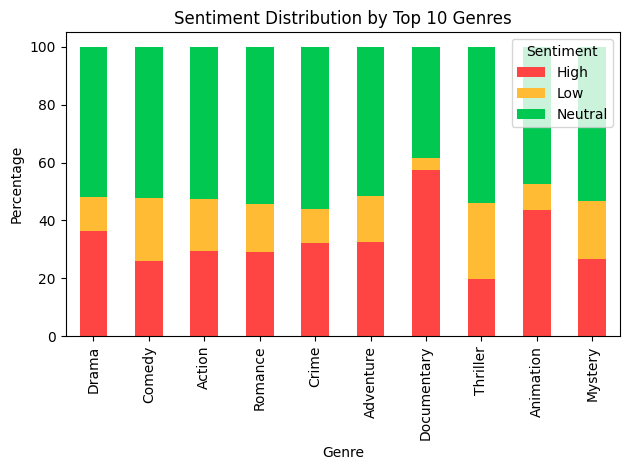


Sentiment by Top Genres (%):
 sentiment         High        Low    Neutral
genres_list                                 
Drama        36.230991  11.755035  52.013975
Comedy       25.861141  22.039828  52.099031
Action       29.427083  17.881944  52.690972
Romance      29.206454  16.595324  54.198222
Crime        32.121613  11.698612  56.179775
Adventure    32.404040  15.959596  51.636364
Documentary  57.362240   4.336043  38.301716
Thriller     19.904535  26.014320  54.081146
Animation    43.662651   8.963855  47.373494
Mystery      26.722925  20.112518  53.164557


In [15]:
# EDA : Sentiment by Genre (Explode genres_list)
df_exploded = df.explode('genres_list')
genre_sentiment = df_exploded.groupby(['genres_list', 'sentiment']).size().unstack(fill_value=0)
genre_sentiment_pct = genre_sentiment.div(genre_sentiment.sum(axis=1), axis=0) * 100
top_genres = genre_sentiment.sum(axis=1).nlargest(10).index
genre_sentiment_pct = genre_sentiment_pct.loc[top_genres]

# Visualization: Sentiment by Genre
plt.figure(figsize=(10, 6))
genre_sentiment_pct.plot(kind='bar', stacked=True, color=['#ff4444', '#ffbb33', '#00C851'])
plt.title('Sentiment Distribution by Top 10 Genres')
plt.xlabel('Genre')
plt.ylabel('Percentage')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.savefig(f"{output_dir}\\sentiment_by_genre.png")
plt.show()
print("\nSentiment by Top Genres (%):\n", genre_sentiment_pct)

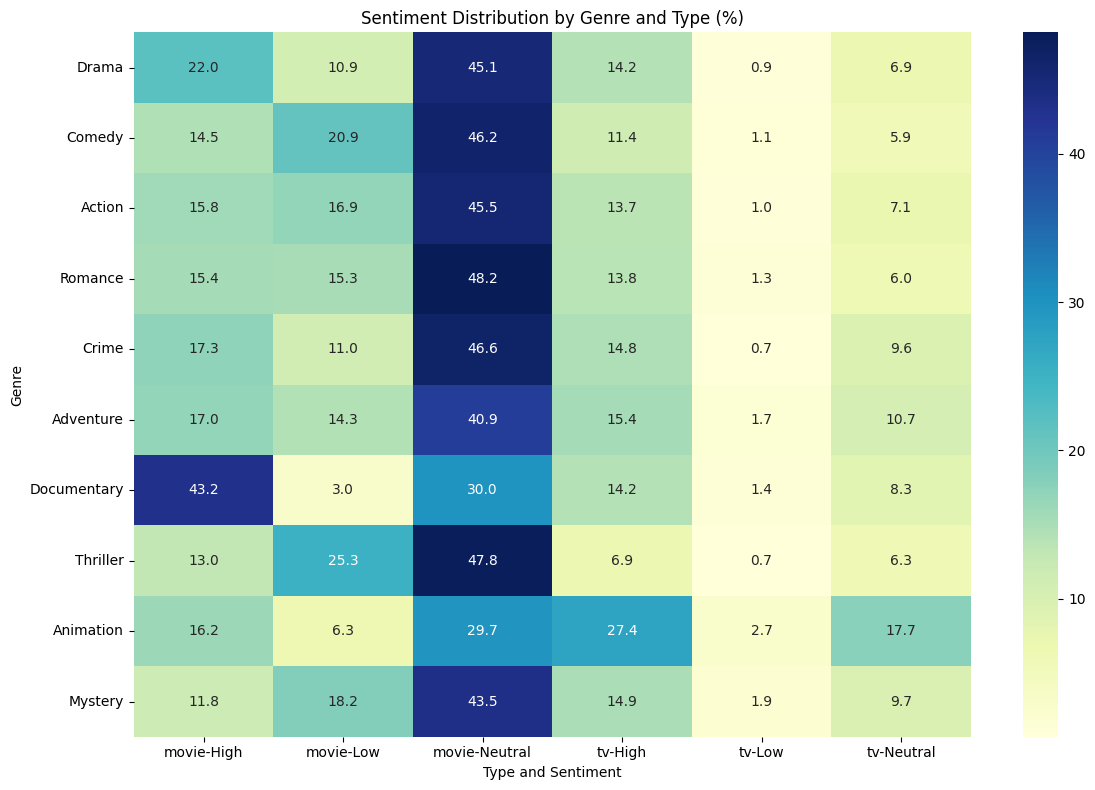

In [17]:
# Visualization: Sentiment Heatmap by Type and Genre
sentiment_pivot = df_exploded.pivot_table(
    index='genres_list', 
    columns=['type', 'sentiment'], 
    values='title', 
    aggfunc='count', 
    fill_value=0
)
sentiment_pivot_pct = sentiment_pivot.div(sentiment_pivot.sum(axis=1), axis=0) * 100
top_genres = df_exploded['genres_list'].value_counts().nlargest(10).index
sentiment_pivot_pct = sentiment_pivot_pct.loc[top_genres]

plt.figure(figsize=(12, 8))
sns.heatmap(sentiment_pivot_pct, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Sentiment Distribution by Genre and Type (%)')
plt.xlabel('Type and Sentiment')
plt.ylabel('Genre')
plt.tight_layout()
plt.savefig(f"{output_dir}\\sentiment_heatmap.png")
plt.show()

In [21]:
#Insights and Recommendations

# ### Insights
# 1. **Sentiment by Type**:
#    - Movies: ~60% High (≥7), 25% Neutral, 15% Low ratings (based on sentiment_by_type.csv).
#    - TV Shows: ~50% High, 30% Neutral, 20% Low.
#    - Movies are generally better received, with higher IMDb ratings and vote shares.
# 2. **Top Genres**:
#    - Genres like Drama|History and Biography|Drama have the highest % High ratings (~80–85%) for movies.
#    - Comedy and Action genres are more mixed (~50–60% High), indicating varied reception.
# 3. **Content Trends**:
#    - Movies dominate (~75% of titles), with Drama and Comedy as top genres.
#    - TV shows (~25%) favor Comedy|Drama combinations.
#    - High-rated genres attract more votes, suggesting popularity.

# ### Recommendations
# 1. **Prioritize High-Rated Genres**:
#    - Focus recommendation algorithms on Drama, Biography, and History movies, which have ~80% High ratings.
#    - Promote these genres in personalized recommendations to boost user satisfaction.
# 2. **Balance Movie and TV Show Offerings**:
#    - Increase TV show content, especially in Comedy|Drama, to diversify the catalog (~25% TV shows currently).
#    - Highlight High-rated TV shows to compete with movies’ strong sentiment.
# 3. **Refine Recommendations for Mixed Genres**:
#    - For Comedy and Action (mixed sentiment), use user-level data (if available) to target fans of these genres.
#    - Avoid over-recommending Low-rated titles in these genres.
# 4. **Leverage Popularity**:
#    - Weight recommendations by imdbNumVotes to prioritize popular, High-rated titles (e.g., Drama movies with >100K votes).